# CS-414 Final Project: Siblings vs. Dating Classification
## Author: Max Votaw

### Problem
This project aims to classify whether two people in a photo are siblings or dating, a binary classification task. The model uses image data and extracted features (face recognition and pose estimation) to make predictions. The dataset is sourced from Reddit and Instagram, labeled as 'siblings' or 'dating.' I incorporated a convolutional neural network (CNN) for raw image data and a dense neural network for non-image features.

**Objective**: Build an AI model that accurately distinguishes between siblings and dating couples based on visual cues

##1. Data Preparation and Exploration
- Download and unzip the dataset.
- Install needed libraries: facenet-pytorch, torchvision, and mediapipe.
- Organize images into train, val, and test folders by copying files.
- Check how many images each class (siblings/dating) has in each split to make sure data is balanced.

**You may have to restart the runtime in order to fully install all the dependencies! I highly recommend using a GPU when training the model**

In [2]:
import os

# Retrieve dataset
if not os.path.exists('./siblings_or_dating'):
    !git clone --depth 1 https://github.com/max17351235123/siblings_or_dating.git
if not os.path.exists('./siblings_or_dating/dataset/train'):
    !unzip siblings_or_dating/dataset.zip -d siblings_or_dating/

In [3]:
!pip install -q facenet-pytorch torchvision mediapipe

In [4]:
import shutil
import cv2
import random
from PIL import Image
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models
from facenet_pytorch import InceptionResnetV1, MTCNN
import mediapipe as mp
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

random.seed(42)
torch.manual_seed(42)
np.random.seed(42)

dataset_dir = './siblings_or_dating/dataset'
splits = ['train', 'val', 'test']
categories = ['siblings', 'dating']


In [5]:
def create_split_folders():
    for split in splits:
        for cat in categories:
            os.makedirs(os.path.join(dataset_dir, split, cat), exist_ok=True)

def split_dataset():
    print("Splitting dataset into train, val, test folders...")
    create_split_folders()
    for cat in categories:
        images = os.listdir(os.path.join(dataset_dir, cat))
        images = [img for img in images if img.lower().endswith(('.png', '.jpg', '.jpeg'))]
        random.shuffle(images)
        n = len(images)
        train_end = int(0.7 * n)
        val_end = int(0.85 * n)
        for i, img in enumerate(images):
            src = os.path.join(dataset_dir, cat, img)
            if i < train_end:
                dst = os.path.join(dataset_dir, 'train', cat, img)
            elif i < val_end:
                dst = os.path.join(dataset_dir, 'val', cat, img)
            else:
                dst = os.path.join(dataset_dir, 'test', cat, img)
            shutil.copy(src, dst)

# Only split if folders not already created (to avoid duplication)
if not os.path.exists(os.path.join(dataset_dir, 'train', 'siblings')):
    split_dataset()

Visualize data split:

Number of images per class in each split: {'train': {'siblings': 158, 'dating': 261}, 'val': {'siblings': 34, 'dating': 56}, 'test': {'siblings': 35, 'dating': 56}}


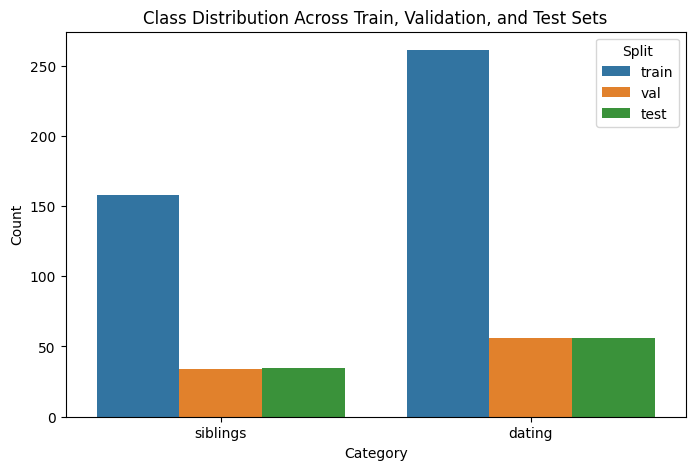

In [6]:
def count_images_per_class_per_split(root_dir, categories, splits):
    counts = {split: {} for split in splits}
    for split in splits:
        for cat in categories:
            path = os.path.join(root_dir, split, cat)
            counts[split][cat] = len(os.listdir(path))
    return counts

counts = count_images_per_class_per_split(dataset_dir, categories, splits)
print("Number of images per class in each split:", counts)

data = []
for split in splits:
    for cat in categories:
        data.append({'Split': split, 'Category': cat, 'Count': counts[split][cat]})

df = pd.DataFrame(data)
plt.figure(figsize=(8,5))
sns.barplot(x='Category', y='Count', hue='Split', data=df)
plt.title("Class Distribution Across Train, Validation, and Test Sets")
plt.show()

##2 - Feature Extraction

- Create a custom dataset class to load images and labels.
- Use MTCNN and FaceNet to extract a face embedding (a numeric representation of the face).
- Use Mediapipe to get pose landmarks (key points on the body).
- Precompute these features for every image to speed up training.
- The dataset returns the image, face features, pose features, and the label (siblings or dating).


In [7]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

mtcnn = MTCNN(image_size=160, margin=20, keep_all=False, post_process=True, device=device)
facenet = InceptionResnetV1(pretrained='vggface2').eval().to(device)

mp_pose = mp.solutions.pose
pose_model = mp_pose.Pose(static_image_mode=True, min_detection_confidence=0.5)

In [8]:
class SiblingsDatingDataset(Dataset):
    def __init__(self, root_dir, split='train', categories=['siblings', 'dating'], transform=None):
        self.root_dir = root_dir
        self.split = split
        self.categories = categories
        self.transform = transform

        self.image_paths = []
        self.labels = []

        for label, cat in enumerate(categories):
            cat_path = os.path.join(root_dir, split, cat)
            for fname in os.listdir(cat_path):
                if fname.lower().endswith(('.png', '.jpg', '.jpeg')):
                    self.image_paths.append(os.path.join(cat_path, fname))
                    self.labels.append(label)

        # Cache dicts to store precomputed features
        self.face_embeddings = {}
        self.pose_features = {}

    def extract_face_embedding(self, image):
        # Use global mtcnn and facenet
        face = mtcnn(image)
        if face is None:
            # fallback: resized full image
            face = transforms.Resize((160, 160))(image)
            face_tensor = transforms.ToTensor()(face).unsqueeze(0).to(device)
        else:
            face_tensor = face.unsqueeze(0).to(device)
        with torch.no_grad():
            embedding = facenet(face_tensor).squeeze(0).cpu()
        return embedding

    def extract_pose_features(self, image):
        # Convert PIL image to numpy BGR for mediapipe
        img_np = np.array(image)
        img_cv = cv2.cvtColor(img_np, cv2.COLOR_RGB2BGR)
        results = pose_model.process(img_cv)
        if not results.pose_landmarks:
            return torch.zeros(33*3)
        keypoints = []
        for lm in results.pose_landmarks.landmark:
            keypoints.extend([lm.x, lm.y, lm.z])
        return torch.tensor(keypoints, dtype=torch.float)

    def precompute_features(self):
        print(f"Precomputing face embeddings and pose features for {self.split} set...")
        for idx, path in enumerate(self.image_paths):
            image = Image.open(path).convert('RGB')
            face_emb = self.extract_face_embedding(image)
            pose_feat = self.extract_pose_features(image)
            self.face_embeddings[idx] = face_emb
            self.pose_features[idx] = pose_feat
            if idx % 100 == 0:
                print(f"Processed {idx} / {len(self.image_paths)}")

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        path = self.image_paths[idx]
        label = self.labels[idx]
        image = Image.open(path).convert('RGB')

        if self.transform:
            image_tensor = self.transform(image)
        else:
            image_tensor = transforms.ToTensor()(image)

        # Use precomputed embeddings/features
        face_emb = self.face_embeddings[idx]
        pose_feat = self.pose_features[idx]

        return image_tensor, face_emb, pose_feat, label

---

## 3. Data augmentation

- Define image transformations for training (resize, flip, color changes) and simpler ones for validation/testing.
- Create dataset objects for training, validation, and testing with the right transformations.
- Precompute face and pose features ahead of time for each dataset.
- Use DataLoaders to load batches of data during training/testing; shuffle training data to improve learning.



In [9]:
train_transform = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.RandomHorizontalFlip(),
    transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485,0.456,0.406], std=[0.229,0.224,0.225])
])

val_test_transform = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485,0.456,0.406], std=[0.229,0.224,0.225])
])

train_dataset = SiblingsDatingDataset(dataset_dir, split='train', transform=train_transform)
val_dataset = SiblingsDatingDataset(dataset_dir, split='val', transform=val_test_transform)
test_dataset = SiblingsDatingDataset(dataset_dir, split='test', transform=val_test_transform)

train_dataset.precompute_features()
val_dataset.precompute_features()
test_dataset.precompute_features()

train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=8, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=8, shuffle=False)

Precomputing face embeddings and pose features for train set...
Processed 0 / 419
Processed 100 / 419
Processed 200 / 419
Processed 300 / 419
Processed 400 / 419
Precomputing face embeddings and pose features for val set...
Processed 0 / 90
Precomputing face embeddings and pose features for test set...
Processed 0 / 91


---

##4. Setup Model Architecture and Run Model

- Build a model combining:
  - A ResNet-18 CNN to get image features.
  - Face embeddings from FaceNet.
  - Pose features from Mediapipe.
- Combine all these features and feed them to a classifier that predicts siblings vs dating.
- Use cross-entropy loss and Adam optimizer for training.

In [10]:
class CombinedClassifier(nn.Module):
    def __init__(self, face_emb_dim=512, pose_feat_dim=33*3, num_classes=2):
        super().__init__()
        self.cnn = models.resnet18(pretrained=True)
        self.cnn.fc = nn.Identity()

        combined_dim = 512 + face_emb_dim + pose_feat_dim

        self.classifier = nn.Sequential(
            nn.Linear(combined_dim, 256),
            nn.ReLU(),
            nn.Dropout(0.4),
            nn.Linear(256, num_classes)
        )

    def forward(self, image, face_emb, pose_feat):
        img_feat = self.cnn(image)
        combined = torch.cat([img_feat, face_emb.to(image.device), pose_feat.to(image.device)], dim=1)
        out = self.classifier(combined)
        return out

model = CombinedClassifier().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1)

def evaluate_metrics(y_true, y_pred):
    acc = accuracy_score(y_true, y_pred)
    precision, recall, f1, _ = precision_recall_fscore_support(y_true, y_pred, average='weighted')
    print(f"Accuracy: {acc:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1-score: {f1:.4f}")

def validate(model, dataloader):
    model.eval()
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for img, face_emb, pose_feat, label in dataloader:
            img = img.to(device)
            face_emb = face_emb.to(device)
            pose_feat = pose_feat.to(device)
            label = label.to(device)
            outputs = model(img, face_emb, pose_feat)
            preds = torch.argmax(outputs, dim=1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(label.cpu().numpy())
    acc = accuracy_score(all_labels, all_preds)
    precision, recall, f1, _ = precision_recall_fscore_support(all_labels, all_preds, average='weighted')
    print(f"Accuracy: {acc:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1-score: {f1:.4f}")
    model.train()
    return acc

# Training loop
epochs = 5
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

for epoch in range(epochs):
    model.train()
    total_train_loss = 0
    train_preds = []
    train_labels = []

    for img, face_emb, pose_feat, label in train_loader:
        img = img.to(device)
        face_emb = face_emb.to(device)
        pose_feat = pose_feat.to(device)
        label = label.to(device)

        optimizer.zero_grad()
        outputs = model(img, face_emb, pose_feat)
        loss = criterion(outputs, label)
        loss.backward()
        optimizer.step()

        total_train_loss += loss.item()

        preds = torch.argmax(outputs, dim=1)
        train_preds.extend(preds.cpu().numpy())
        train_labels.extend(label.cpu().numpy())

    scheduler.step()

    # Compute and store training metrics
    avg_train_loss = total_train_loss / len(train_loader)
    train_losses.append(avg_train_loss)
    train_acc = accuracy_score(train_labels, train_preds)
    train_accuracies.append(train_acc)

    # Validation phase
    model.eval()
    val_preds = []
    val_labels = []
    val_total_loss = 0

    with torch.no_grad():
        for img, face_emb, pose_feat, label in val_loader:
            img = img.to(device)
            face_emb = face_emb.to(device)
            pose_feat = pose_feat.to(device)
            label = label.to(device)

            outputs = model(img, face_emb, pose_feat)
            val_loss = criterion(outputs, label)
            val_total_loss += val_loss.item()

            preds = torch.argmax(outputs, dim=1)
            val_preds.extend(preds.cpu().numpy())
            val_labels.extend(label.cpu().numpy())

    avg_val_loss = val_total_loss / len(val_loader)
    val_losses.append(avg_val_loss)
    val_acc = accuracy_score(val_labels, val_preds)
    val_accuracies.append(val_acc)

    print(f"\nEpoch {epoch+1}/{epochs}")
    print(f"Train Loss: {avg_train_loss:.4f}, Train Acc: {train_acc:.4f}")
    print(f"Val Loss: {avg_val_loss:.4f}, Val Acc: {val_acc:.4f}")


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)



Epoch 1/5
Train Loss: 0.6610, Train Acc: 0.6038
Val Loss: 0.6380, Val Acc: 0.6667

Epoch 2/5
Train Loss: 0.5256, Train Acc: 0.7518
Val Loss: 0.6310, Val Acc: 0.6222

Epoch 3/5
Train Loss: 0.3256, Train Acc: 0.8854
Val Loss: 0.7984, Val Acc: 0.6000

Epoch 4/5
Train Loss: 0.1966, Train Acc: 0.9379
Val Loss: 0.7574, Val Acc: 0.6111

Epoch 5/5
Train Loss: 0.1841, Train Acc: 0.9451
Val Loss: 0.7555, Val Acc: 0.6111


In [11]:
# Final test set evaluation
model.eval()
all_preds = []
all_labels = []
with torch.no_grad():
    for img, face_emb, pose_feat, label in test_loader:
        img = img.to(device)
        face_emb = face_emb.to(device)
        pose_feat = pose_feat.to(device)
        label = label.to(device)
        outputs = model(img, face_emb, pose_feat)
        preds = torch.argmax(outputs, dim=1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(label.cpu().numpy())

test_acc = accuracy_score(all_labels, all_preds)
print(f"\nFinal Test Accuracy: {test_acc:.4f}")



Final Test Accuracy: 0.6703


##5. Test Model and plot performance

- Plot the training loss per epoch
- Plot the validation accuracy vs the training accuracy

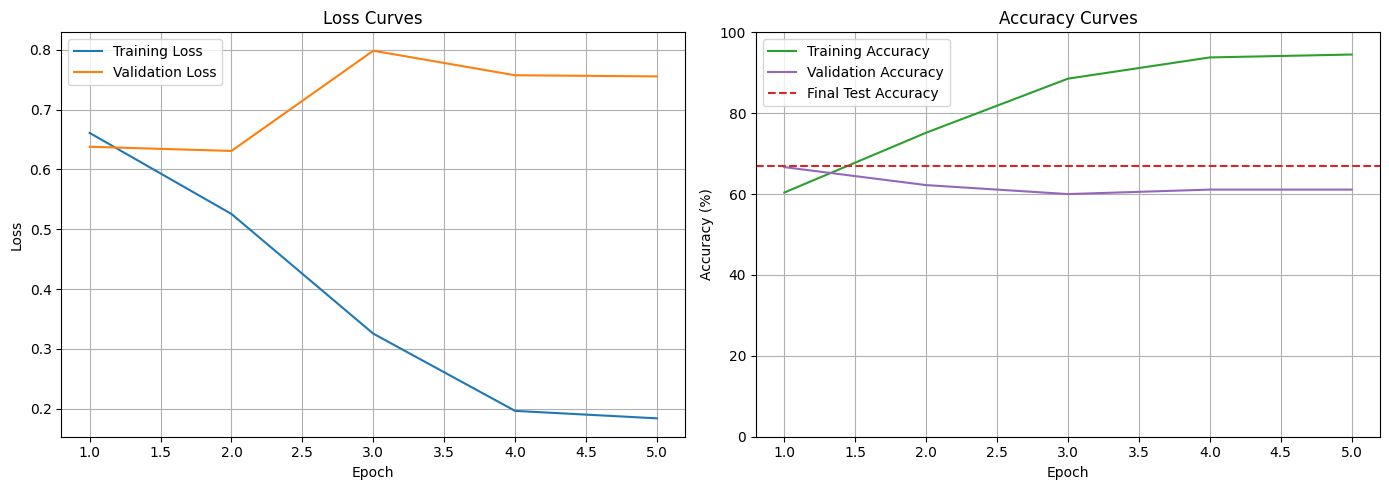

In [12]:
import matplotlib.pyplot as plt

plt.figure(figsize=(14, 5))

# Plot 1: Loss Curves
plt.subplot(1, 2, 1)
plt.plot(range(1, epochs + 1), train_losses, label="Training Loss", color="tab:blue")
plt.plot(range(1, epochs + 1), val_losses, label="Validation Loss", color="tab:orange")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Loss Curves")
plt.grid(True)
plt.legend()

# Plot 2: Accuracy Curves
plt.subplot(1, 2, 2)
plt.plot(range(1, epochs + 1), [acc * 100 for acc in train_accuracies], label="Training Accuracy", color="tab:green")
plt.plot(range(1, epochs + 1), [acc * 100 for acc in val_accuracies], label="Validation Accuracy", color="tab:purple")
plt.axhline(y=test_acc * 100, color="tab:red", linestyle="--", label="Final Test Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy (%)")
plt.title("Accuracy Curves")
plt.ylim(0, 100)
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.show()


In [13]:
print("Final Test Set Evaluation:")
validate(model, test_loader)

Final Test Set Evaluation:
Accuracy: 0.6703
Precision: 0.6644
Recall: 0.6703
F1-score: 0.6660


0.6703296703296703

##6. Model Demonstration

I test the model on 6 images in my testing set so you can see how it is classifying each image.

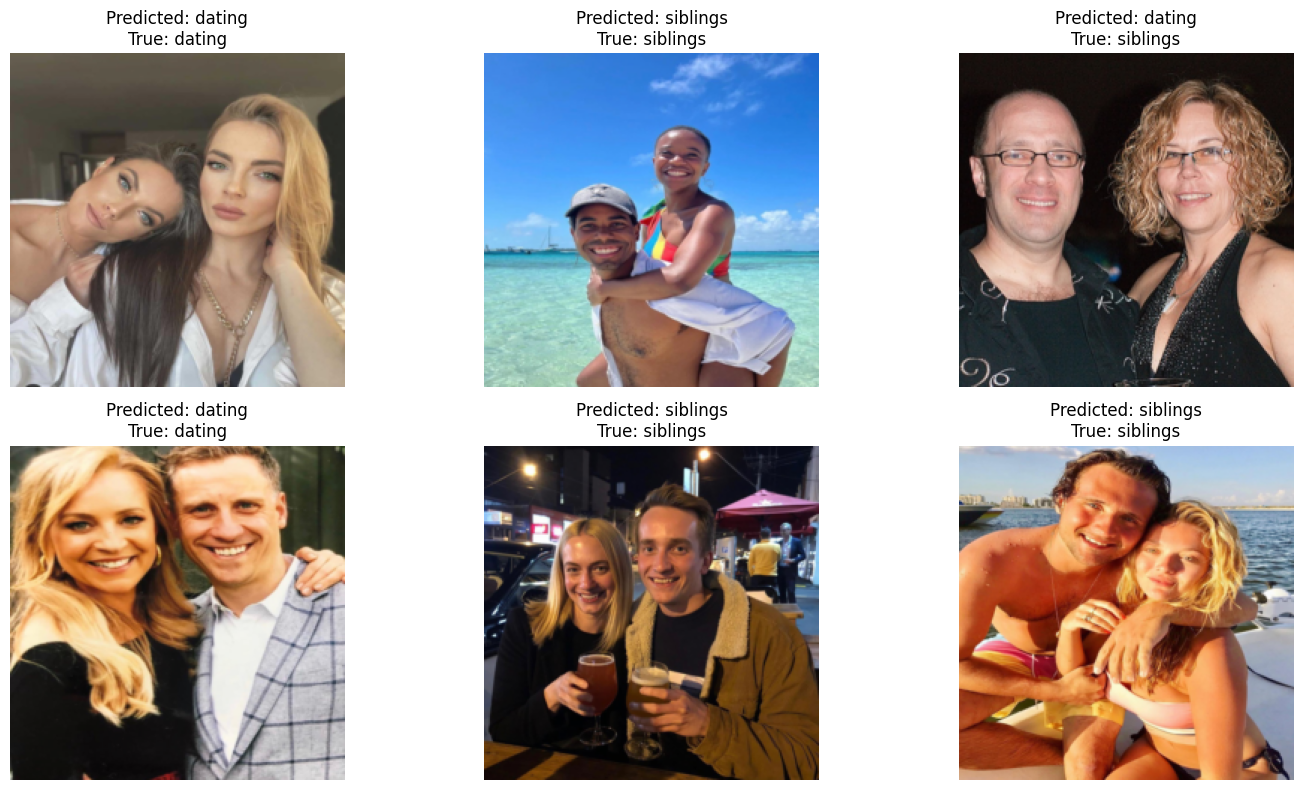

In [14]:
import matplotlib.pyplot as plt
import random
import numpy as np

def predict_and_display_samples(model, test_dataset, device, num_samples=6):
    model.eval()
    label_map = {0: 'siblings', 1: 'dating'}

    samples = random.sample(range(len(test_dataset)), num_samples)

    plt.figure(figsize=(15, 8))
    with torch.no_grad():
        for i, idx in enumerate(samples):
            image_tensor, face_emb, pose_feat, true_label = test_dataset[idx]

            # Add batch dimension and move to device
            img = image_tensor.unsqueeze(0).to(device)
            face = face_emb.unsqueeze(0).to(device)
            pose = pose_feat.unsqueeze(0).to(device)

            output = model(img, face, pose)
            pred_label = torch.argmax(output, dim=1).item()

            # Convert tensor to numpy image for display
            img_np = image_tensor.permute(1, 2, 0).cpu().numpy()
            img_np = (img_np * np.array([0.229, 0.224, 0.225]) + np.array([0.485, 0.456, 0.406]))  # unnormalize
            img_np = np.clip(img_np, 0, 1)

            plt.subplot(2, 3, i+1)
            plt.imshow(img_np)
            plt.axis('off')
            plt.title(f"Predicted: {label_map[pred_label]}\nTrue: {label_map[true_label]}")
    plt.tight_layout()
    plt.show()

# examples of my model's predicitons:
predict_and_display_samples(model, test_dataset, device, num_samples=6)